In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import os
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torchvision import transforms
import timm

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
SEED = 85
torch.manual_seed(SEED)
np.random.seed(SEED)

class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Paths']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        labels = self.dataframe.iloc[idx][disease_labels].values.astype(np.float32)
        return image, torch.tensor(labels)

labels_train_val = pd.read_csv('../../../../..//data/train_val_list.txt')
labels_train_val.columns = ['Image_Index']
labels_test = pd.read_csv('../../../../..//data/test_list.txt')
labels_test.columns = ['Image_Index']

disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']

labels_df = pd.read_csv('../../../../..//data/Data_Entry_2017.csv')
labels_df.columns = ['Image_Index', 'Finding_Labels', 'Follow_Up_#', 'Patient_ID',
                  'Patient_Age', 'Patient_Gender', 'View_Position',
                  'Original_Image_Width', 'Original_Image_Height',
                  'Original_Image_Pixel_Spacing_X',
                  'Original_Image_Pixel_Spacing_Y', 'dfd']

for disease in tqdm(disease_labels): 
    labels_df[disease] = labels_df['Finding_Labels'].map(lambda result: 1 if disease in result else 0)

labels_df['Finding_Labels'] = labels_df['Finding_Labels'].apply(lambda s: [l for l in str(s).split('|')])

num_glob = glob('../../../../../data/images_all/*.png')
img_path = {os.path.basename(x): x for x in num_glob}

labels_df['Paths'] = labels_df['Image_Index'].map(img_path.get)

train_val_df = labels_df[labels_df['Image_Index'].isin(labels_train_val['Image_Index'])]
test_df = labels_df[labels_df['Image_Index'].isin(labels_test['Image_Index'])]

print('train_val size', train_val_df.shape[0])
print('test size', test_df.shape[0])


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터 로더 설정
test_dataset = ChestXRayDataset(test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# 모델 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = timm.create_model('coatnet_2_rw_224', pretrained=True)
model = timm.create_model('coatnet_2_rw_224.sw_in12k_ft_in1k', pretrained=True)
model.reset_classifier(len(disease_labels))  # 출력 레이어 조정
model = nn.DataParallel(model)
model.to(device)

# 모델 가중치만 로드하기
checkpoint = torch.load('models/coatnet-70-10-20-split.pth')
model.load_state_dict(checkpoint['model'], strict=False)

# 평가
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        all_preds.append(outputs.sigmoid().cpu())
        all_targets.append(labels.cpu())
        
all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

100%|██████████| 15/15 [00:00<00:00, 31.79it/s]


train_val size 86523
test size 25595


  0%|          | 0/800 [00:02<?, ?it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/userHome/userhome4/seungyeon/miniconda3/envs/nih_syn/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/userHome/userhome4/seungyeon/miniconda3/envs/nih_syn/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/userHome/userhome4/seungyeon/miniconda3/envs/nih_syn/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_2924898/2722885023.py", line 35, in __getitem__
    image = self.transform(image)
  File "/userHome/userhome4/seungyeon/miniconda3/envs/nih_syn/lib/python3.9/site-packages/torchvision/transforms/transforms.py", line 94, in __call__
    img = t(img)
  File "/userHome/userhome4/seungyeon/miniconda3/envs/nih_syn/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/userHome/userhome4/seungyeon/miniconda3/envs/nih_syn/lib/python3.9/site-packages/torchvision/transforms/transforms.py", line 269, in forward
    return F.normalize(tensor, self.mean, self.std, self.inplace)
  File "/userHome/userhome4/seungyeon/miniconda3/envs/nih_syn/lib/python3.9/site-packages/torchvision/transforms/functional.py", line 360, in normalize
    return F_t.normalize(tensor, mean=mean, std=std, inplace=inplace)
  File "/userHome/userhome4/seungyeon/miniconda3/envs/nih_syn/lib/python3.9/site-packages/torchvision/transforms/functional_tensor.py", line 959, in normalize
    tensor.sub_(mean).div_(std)
RuntimeError: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]


In [ ]:
# Convert predictions to binary (thresholding)
preds_binary = (all_preds > 0.5).int()

# Initialize metrics
accuracy_per_disease = []
f1_per_disease = []
roc_auc_per_disease = []

# Calculate metrics for each disease
for i, disease in enumerate(disease_labels):
    accuracy = accuracy_score(all_targets[:, i], preds_binary[:, i])
    f1 = f1_score(all_targets[:, i], preds_binary[:, i])
    roc_auc = roc_auc_score(all_targets[:, i], all_preds[:, i])
    
    accuracy_per_disease.append(accuracy)
    f1_per_disease.append(f1)
    roc_auc_per_disease.append(roc_auc)
    
    # print(f'{disease}:')
    # print(f'  Accuracy: {accuracy:.4f}')
    # print(f'  F1 Score: {f1:.4f}')
    # print(f'  ROC AUC: {roc_auc:.4f}')
    # print()

# 결과를 데이터프레임으로 변환하여 시각화
results_df = pd.DataFrame({
    'Disease': disease_labels,
    'Accuracy': accuracy_per_disease,
    'F1 Score': f1_per_disease,
    'ROC AUC': roc_auc_per_disease
})

display(results_df)


,Disease,Accuracy,F1 Score,ROC AUC
0,Atelectasis,0.128267,0.227156,0.536553
1,Consolidation,0.091033,0.133487,0.605676
2,Infiltration,0.529830,0.329433,0.516973
3,Pneumothorax,0.806056,0.112303,0.521360
4,Edema,0.036452,0.069780,0.466336
5,Emphysema,0.939090,0.011414,0.460118
6,Fibrosis,0.017738,0.033447,0.440649
7,Effusion,0.279078,0.311749,0.565717
8,Pneumonia,0.132604,0.040538,0.450267
9,Pleural_Thickening,0.081227,0.085052,0.477046


In [ ]:
for i, disease in enumerate(disease_labels):
    # accuracy = accuracy_score(all_targets[:, i], preds_binary[:, i])
    if disease == "Hernia":
        print(sum(all_targets[:, i]))
        print(sum(preds_binary[:, i]))

tensor(85.)
tensor(61, dtype=torch.int32)


In [ ]:
results_df.to_csv("result_main_stage1.csv", index_label = False)

In [ ]:
print(f"Total Accuracy : {np.mean(results_df['Accuracy'])}")
print(f"Total F1 Score : {np.mean(results_df['F1 Score'])}")
print(f"Total ROC AUC : {np.mean(results_df['ROC AUC'])}")

Total Accuracy : 0.33797486488246403
Total F1 Score : 0.13697571954778762
Total ROC AUC : 0.4906018420385862


## XGB

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from glob import glob
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import xgboost as xgb
from torchvision import models, transforms
from PIL import Image
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
import pickle

import xgboost as xgb
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm.notebook import tqdm
import numpy as np

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
# 피클 파일에서 데이터 로드
with open('train_val_features.pkl', 'rb') as f:
    train_val_data = pickle.load(f)

with open('test_features.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [ ]:
# # 특징과 레이블 분리
X_train = np.stack(train_val_data['features'])
y_train = train_val_df[disease_labels].values

X_test = np.stack(test_data['features'])
y_test = test_df[disease_labels].values

num_classes = 15

# XGBoost 모델 설정
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    num_class=num_classes,
    use_label_encoder=False,
    tree_method='gpu_hist',  # GPU를 사용하도록 설정
    gpu_id=3  # 특정 GPU를 지정
)

# tqdm 콜백 클래스 정의
class TqdmCallback(xgb.callback.TrainingCallback):
    def __init__(self, total, desc):
        self.total = total
        self.pbar = tqdm(total=total, desc=desc)

    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)
        if epoch == self.total - 1:
            self.pbar.close()
        return False

# OneVsRestClassifier로 멀티레이블 분류기 설정
epochs = 20
multilabel_model = OneVsRestClassifier(xgb_model)

columns = [	"Time",
			"Accuracy",
			"F1_macro",
			"Roc_Auc_macro"]

In [ ]:
# 모델 학습을 위한 맞춤 fit 함수 정의
def custom_fit(model, X_train, y_train, epochs):
    print("Model Fit Start")

    for i in range(y_train.shape[1]):
        print(f"Training for label {i}")
        model.estimator.fit(
            X_train, 
            y_train[:, i], 
            eval_set=[(X_train, y_train[:, i]), (X_test, y_test[:, i])],
            verbose=False, 
            callbacks=[TqdmCallback(epochs, desc=f'Training label {i}')]
        )

# 모델 학습
custom_fit(multilabel_model, X_train, y_train, epochs)

Model Fit Start
Training for label 0


Training label 0:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 1


Training label 1:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 2


Training label 2:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 3


Training label 3:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 4


Training label 4:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 5


Training label 5:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 6


Training label 6:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 7


Training label 7:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 8


Training label 8:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 9


Training label 9:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 10


Training label 10:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 11


Training label 11:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 12


Training label 12:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 13


Training label 13:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 14


Training label 14:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# 예측
y_pred = multilabel_model.estimator.predict(X_test)
y_pred_proba = multilabel_model.estimator.predict_proba(X_test)  # AUC-ROC 계산을 위해 필요

# 정확도 및 F1 스코어 계산
accuracy = accuracy_score(y_test, y_pred)
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')

# AUC-ROC 스코어 계산
roc_auc_micro = roc_auc_score(y_test, y_pred_proba, average='micro')
roc_auc_macro = roc_auc_score(y_test, y_pred_proba, average='macro')

print(f"Test Accuracy: {accuracy}")
# print(f"Test F1 Score (Micro): {f1_micro}")   # 라벨에 상관없이 전체적인 성능 평가 (==accuracy와 동일)
print(f"Test F1 Score (Macro): {f1_macro}")     # 모든 라벨이 유사한 중요도를 가져 단순 라벨들의 f1_score의 산술평균
# print(f"Test ROC AUC Score (Micro): {roc_auc_micro}") 
print(f"Test ROC AUC Score (Macro): {roc_auc_macro}")

# 각 레이블별 평가 결과 출력
for idx in range(y_test.shape[1]):
    accuracy_label = accuracy_score(y_test[:, idx], y_pred[:, idx])
    f1_label = f1_score(y_test[:, idx], y_pred[:, idx])
    roc_auc_label = roc_auc_score(y_test[:, idx], y_pred_proba[:, idx])
    print(f"Class {idx} - Accuracy: {accuracy_label}, F1 Score: {f1_label}, ROC AUC Score: {roc_auc_label}")


Test Accuracy: 0.022152764211760108
Test F1 Score (Macro): 0.020737174922037267
Test ROC AUC Score (Macro): 0.4948972736133399
Class 0 - Accuracy: 0.5162727095135768, F1 Score: 0.19546429267658716, ROC AUC Score: 0.48662868222177436
Class 1 - Accuracy: 0.47149833951943737, F1 Score: 0.11559333115397188, ROC AUC Score: 0.47049563607633793
Class 2 - Accuracy: 0.7612033600312561, F1 Score: 0.0, ROC AUC Score: 0.4988517266563171
Class 3 - Accuracy: 0.895878101191639, F1 Score: 0.0, ROC AUC Score: 0.4933712686216064
Class 4 - Accuracy: 0.9638601289314319, F1 Score: 0.0, ROC AUC Score: 0.4891093460708378
Class 5 - Accuracy: 0.9572963469427622, F1 Score: 0.0, ROC AUC Score: 0.49860483409573597
Class 6 - Accuracy: 0.9830044930650518, F1 Score: 0.0, ROC AUC Score: 0.5219617893755825
Class 7 - Accuracy: 0.8180113303379566, F1 Score: 0.0, ROC AUC Score: 0.49914744540312955
Class 8 - Accuracy: 0.9783160773588592, F1 Score: 0.0, ROC AUC Score: 0.4959062257145324
Class 9 - Accuracy: 0.95534284039851

## 앙상블 결과

In [ ]:
# Define weights
weight_fastai = 0.7  # You can adjust these weights based on model performance
weight_xgboost = 0.3

# Ensure the predictions are in the same format
preds_xgboost = np.array(y_pred_proba)

# Weighted ensemble predictions
ensemble_preds = weight_fastai * all_preds + weight_xgboost * preds_xgboost


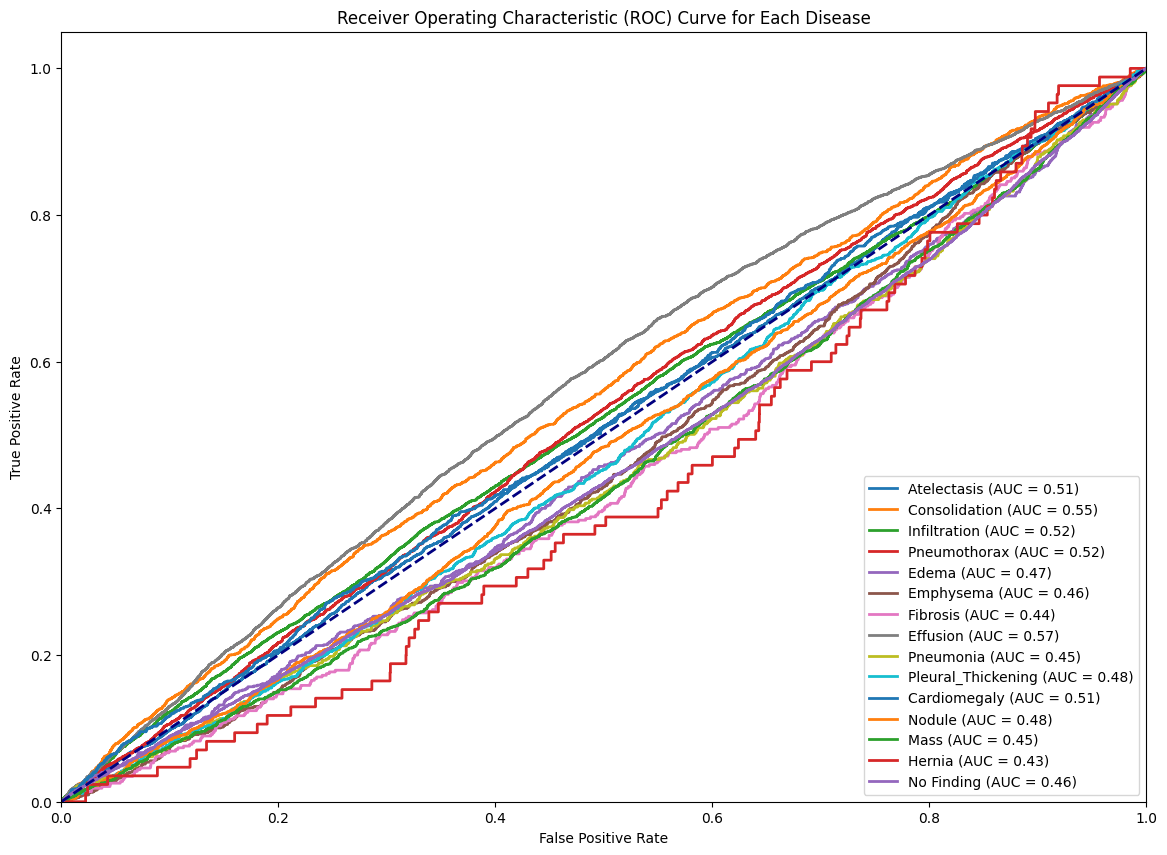

Atelectasis - ROC AUC Score: 0.5056
Consolidation - ROC AUC Score: 0.5476
Infiltration - ROC AUC Score: 0.5170
Pneumothorax - ROC AUC Score: 0.5214
Edema - ROC AUC Score: 0.4663
Emphysema - ROC AUC Score: 0.4601
Fibrosis - ROC AUC Score: 0.4406
Effusion - ROC AUC Score: 0.5657
Pneumonia - ROC AUC Score: 0.4503
Pleural_Thickening - ROC AUC Score: 0.4770
Cardiomegaly - ROC AUC Score: 0.5124
Nodule - ROC AUC Score: 0.4780
Mass - ROC AUC Score: 0.4470
Hernia - ROC AUC Score: 0.4255
No Finding - ROC AUC Score: 0.4554


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Plot ROC curve for each class
plt.figure(figsize=(14, 10))
for i, disease in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(all_targets[:, i].cpu(), ensemble_preds[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{disease} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Disease')
plt.legend(loc='lower right')
plt.show()

# Print ROC AUC scores for each class
for i, disease in enumerate(disease_labels):
    roc_auc_label = roc_auc_score(all_targets[:, i].cpu(), ensemble_preds[:, i])
    print(f'{disease} - ROC AUC Score: {roc_auc_label:.4f}')
